# Pneumonia Detection in Chest X-Rays: Build and Train Model

---

# Import

In [1]:
%%capture
!pip install opencv-python

In [2]:
import cv2

In [78]:
random_seed = 333

import os
from glob import glob

from IPython.display import Image

import time

import numpy as np
import pandas as pd
from random import sample

from numpy.random import seed
seed(random_seed)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
import seaborn as sns
sns.set(style="darkgrid")

from skimage import io, color
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import keras.backend as K
from keras.models import Sequential, Model, model_from_json#, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [4]:
def load_model(model_path, weight_path):
   
    json_file = open(model_path, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(weight_path)
    
    return model

In [5]:
def get_unique_labels(col):
    """
    This function takes a column, in our case 'Finding Labels'.
    Splits the strings and finds unique label values,
    stores these values in a set.
    """
    labels = set()
    for l in col.unique():
        labels.update(l.split('|'))
    print('Total unique labels: {}'.format(len(labels)))
    return labels

In [6]:
def split_col_labels(df, labels):
    """
    This function takes a set of labels and a dataframe.
    Splits the labels listed in the column 'Finding Labels'
    into seperate columns with value 1 for found and 0 for absent.
    """
    for l in labels:
        df[l] = df['Finding Labels'].map(lambda x: 1 if l in x else 0)
    return df

In [7]:
def create_splits(df, random_seed):
    df_train, df_val = train_test_split(df,
                                  test_size = 0.2,
                                  random_state= random_seed,
                                  stratify = df['class'])
    
    p_train_ratio = len(df_train[df_train['class'] == 'P'])/len(df_train)
    p_val_ratio = len(df_val[df_val['class'] == 'P'])/len(df_val)
    print('''Train set: \t\t{}\nVal set: \t\t{}\nTrain % Pneumonia: \t{:.2f}%\nVal % Pneumonia: \t{:.2f}%'''.format(df_train.shape[0],
                                    df_val.shape[0],
                                    p_train_ratio*100,
                                    p_val_ratio*100))
    return df_train, df_val

In [8]:
def balance_train_target_proportions(df_train):
    p_inds = df_train[df_train['class']=='P'].index.tolist()
    np_inds = df_train[df_train['class']=='N'].index.tolist()
    np_sample = sample(np_inds,len(p_inds))
    return df_train.loc[p_inds + np_sample]

In [9]:
def balance_val_target_proportions(df_val):
    p_inds = df_val[df_val['class']=='P'].index.tolist()
    np_inds = df_val[df_val['class']=='N'].index.tolist()
    np_sample = sample(np_inds,len(p_inds)*4) # for a 20/80 split
    return df_val.loc[p_inds + np_sample]

In [10]:
def check_patient_leakage(df1, df2, col_patient):
    """
    Return True if patients are in both given df, otherwise False.
    """
    
    df1_patients_unique = set(df1[col_patient].values)
    df2_patients_unique = set(df2[col_patient].values)
    double_patients = df1_patients_unique.intersection(df2_patients_unique)
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(double_patients)>0 
    return leakage

In [11]:
def get_idg():

    return ImageDataGenerator(
        rescale=1.0/255.0,
        samplewise_center=True,
        samplewise_std_normalization= True,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.05,
        zoom_range=0.15,
        #zca_whitening=True
    )

In [12]:
def make_train_gen(df_train, img_size):
    
    train_idg = get_idg()
    train_gen = train_idg.flow_from_dataframe(
        dataframe=df_train,
        shuffle = True,
        x_col = 'img_path',
        y_col = 'class',
        class_mode = 'binary',
        target_size = img_size,
        batch_size = 128
    )
    return train_gen

In [13]:
def make_val_gen(df_val, img_size):
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0) #shouldnt augment ecept for scaling
    val_gen = val_idg.flow_from_dataframe(
        dataframe=df_val,
        shuffle = False,
        x_col = 'img_path',
        y_col = 'class',
        class_mode = 'binary',
        target_size = img_size,
        batch_size = 1024 # use larger batch for eval
    )
    return val_gen

In [14]:
def plot_img_gen(gen, nrows, ncols):
    t_x, t_y = next(gen)
    fig, m_axs = plt.subplots(nrows, ncols, figsize = (16, 16))
    for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
        c_ax.imshow(c_x[:,:,0], cmap = 'bone')
        if c_y == 1: 
            c_ax.set_title('Pneumonia')
        else:
            c_ax.set_title('No Pneumonia')
        c_ax.axis('off')

In [15]:
def load_vgg_model():
    
    model = VGG16(
        include_top=True,
        weights='imagenet'
    )
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                      outputs=transfer_layer.output)
    
    ## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
    ## Here, we'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model

In [16]:
def load_mobilenet_model():
    
    mobilenet_model = MobileNet(include_top = False,
                                weights = 'imagenet')
    
    return mobilenet_model

In [17]:
def batch_norm(pretrain_model):
    
    pretrain_features = Input(pretrain_model.get_output_shape_at(0)[1:], name = 'feature_input')
    pretrain_depth = pretrain_model.get_output_shape_at(0)[-1]
    batchnorm_features = BatchNormalization(name='features_batch_norm')(pretrain_features)
    
    return pretrain_features, pretrain_depth, batchnorm_features

In [18]:
def build_attn_model(pretrain_features, pretrain_depth, batchnorm_features, optimizer):
    attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(batchnorm_features)
    attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer) # smooth results
    attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid', name='AttentionMap2D')(attn_layer)

    up_c2_w = np.ones((1, 1, 1, pretrain_depth))
    up_c2 = Conv2D(pretrain_depth, kernel_size = (1,1), padding = 'same', name='UpscaleAttention',
                   activation = 'linear', use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)

    mask_features = multiply([attn_layer, batchnorm_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])

    gap_dr = Dropout(0.5)(gap)
    dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
    out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

    attn_model = Model(inputs = [pretrain_features], outputs = [out_layer], name = 'attention_model')

    attn_model.compile(optimizer = optimizer,
                       loss = 'binary_crossentropy',
                       metrics = ['binary_accuracy'])

    #attn_model.summary()

    return attn_model


In [19]:
def build_model_vgg_attn():
    pretrain_model = load_vgg_model()
    pretrain_model.trainable = False
    pretrain_features, pretrain_depth, batchnorm_features = batch_norm(pretrain_model)

    new_model = Sequential(name = 'VGG attention model')
    new_model.add(pretrain_model)
    new_model.add(build_attn_model(pretrain_features, pretrain_depth, batchnorm_features, optimizer))
    
    return new_model

In [20]:
def build_model_vgg():

    pretrain_model = load_vgg_model()
    pretrain_model.trainable = False    

    new_model = Sequential(name = 'VGG new model')

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(pretrain_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())
    new_model.add(Dropout(0.2))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid'))
    
    return new_model

In [21]:
def build_model_mobnet():

    pretrain_model = load_mobilenet_model()

    x = pretrain_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x = Dropout(rate=0.2)(x)
    x = Dense(1024,activation='relu')(x) #dense layer 2
    x = Dropout(rate=0.2)(x)
    x = Dense(512,activation='relu')(x) #dense layer 3
    preds = Dense(1,activation='sigmoid')(x) #final layer with softmax activation

    new_model = Model(inputs=pretrain_model.input,outputs=preds)
   
    for layer in new_model.layers[:20]:
        layer.trainable=False
    for layer in new_model.layers[20:]:
        layer.trainable=True

    return new_model

In [22]:
def plot_history_sep(history, model_name):
    f = plt.figure()
    f.set_figwidth(10)

    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()

    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
    plt.plot(history.history['binary_accuracy'], label='train accuracy')
    plt.legend();
    plt.savefig('{}-history-plot-sep.png'.format(model_name))

In [23]:
def plot_history_tog(history, model_name):
    N = len(history.history["loss"])
    #plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left");
    plt.savefig('{}-history-plot-tog.png'.format(model_name))

In [24]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.savefig('{}-auc-plot.png'.format(model_name))
    plt.show()

def plot_pr(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig('{}-pr-plot.png'.format(model_name))
    plt.show()
    
def plot_pr_th(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
    plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
    plt.xlabel('Threshold')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Precision-Recall by Threshold')
    plt.savefig('{}-prth-plot.png'.format(model_name))
    plt.show()

In [25]:
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

def find_optimal_th(y_val, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
    idx = np.argmax(f1score)
    
    plt.figure()
    plt.plot(thresholds, f1score)
    plt.title("F1 score vs. threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 score")
    plt.show()

    print('Precision: '+ str(precision[idx]))
    print('Recall: '+ str(recall[idx]))
    print('Threshold: '+ str(thresholds[idx]))
    print('F1 Score: ' + str(f1score[idx]))
    
    return thresholds[idx]

---

# Variables

The VGG neural net has two sections of layers: the "feature" layer and the "classifier" layer. The input to the feature layer is always an image of size 224 x 224 pixels.

In [26]:
img_size = (224, 224)

---

# Load data

In [27]:
## Load the NIH data
df_all_xray = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', df_all_xray.shape[0])
df_all_xray['img_path'] = df_all_xray['Image Index'].map(all_image_paths.get)
df_all_xray = df_all_xray.drop('Unnamed: 11', axis=1)
df_all_xray.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
13972   00003610_003.png     No Finding            3        3610           29   
110179  00029989_000.png         Nodule            0       29989           31   
60956   00015043_000.png         Nodule            0       15043           35   

       Patient Gender View Position  OriginalImage[Width  Height]  \
13972               F            PA                 2992     2991   
110179              M            PA                 2021     2021   
60956               M            PA                 2992     2991   

        OriginalImagePixelSpacing[x        y]  \
13972                      0.143000  0.143000   
110179                     0.194314  0.194314   
60956                      0.143000  0.143000   

                                        img_path  
13972   /data/images_002/images/00003610_003.png  
110179  /data/images_012/images/00029989_000.png  
60956   /data/images_007/images/00015043_000.png

---

# Split finding labels

In [28]:
labels = get_unique_labels(df_all_xray['Finding Labels'])

Total unique labels: 15


In [29]:
df_all_xray = split_col_labels(df_all_xray, labels)

---

# Preprocessing

In [30]:
# Encode Male = 1, Female = 0
df_all_xray['Patient Gender'] = df_all_xray['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')

In [31]:
# Drop any age outliers above 100
df_all_xray['Patient Age'] = np.clip(df_all_xray['Patient Age'], 1, 100)

In [32]:
df_all_xray['class'] = df_all_xray['Pneumonia'].map(lambda x: 'P' if x == 1 else 'N')

---

# Split train and val data

Ideally, we want to train our model using an evenly balanced dataset, such that positive and negative cases contribute equally to loss. If we use a normal cross-entropy loss function with a highly unbalanced dataset, then the algorithm will be incentivized to prioritize the majority class (since it contributes more to the loss).

The stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

We want our model to be trained on a set that has equal proportions of pneumonia and no pneumonia, so we're going to have to throw away some data.

In EDA, we found that:
* #pneumonia records: 	1431 (1.28%)
* #no-pneumonia records: 	110689 (98.72%)

It is preferable that the distribution of classes in the validation set reflects the distribution of classes in the test set, so that performance metrics on the validation set are a good approximation of the performance metrics on the test set. In other words, the validation set should reflect the original data imbalance.

**Note**: We ran out of GPU usage. The following models were trained on 20/80 split for the validation set. This is a ratio that was decided on, further discussion can be read [here](https://knowledge.udacity.com/questions/325157). However, a validation set with such a split might not be representative of real-life data.

In [33]:
df_train, df_val = create_splits(df_all_xray, random_seed)

df_train = balance_train_target_proportions(df_train)

p_train_ratio = len(df_train[df_train['class'] == 'P'])/len(df_train)    
print('''\nBalanced train set 50/50.\nTrain % Pneumonia: \t{:.2f}%'''.format(p_train_ratio*100))

df_val = balance_val_target_proportions(df_val)

p_val_ratio = len(df_val[df_val['class'] == 'P'])/len(df_val)
print('''\nBalanced train set 20/80.\nVal % Pneumonia: \t{:.2f}%'''.format(p_val_ratio*100))

Train set: 		89696
Val set: 		22424
Train % Pneumonia: 	1.28%
Val % Pneumonia: 	1.28%

Balanced train set 50/50.
Train % Pneumonia: 	50.00%

Balanced train set 20/80.
Val % Pneumonia: 	20.00%


In [34]:
print('''Train set: \t\t{}\nVal set: \t\t{}'''.format(df_train.shape[0],
                                                  df_val.shape[0]))

Train set: 		2290
Val set: 		1430


## Data Leakage

The dataset contains multiple images for some patient (see EDA). The data splitting should be done on patient level to avoid data leakage.

In [35]:
check_patient_leakage(df_train, df_val, 'Patient ID')

True

Oh noes! We have data leakage :( In the future, this should be properly addressed.

---

# Chest X-Rays

* Black = Air
* White = Bone
* Grey = Tissue or Fluid

---

# Image Augmentation

* **Pixel Normalization**: scale pixel values from the range of 0-255 to the range 0-1 preferred for neural network models
* **Pixel Centering**: scale pixel values to have a zero mean. 
* **Pixel Standardization**: scale pixel values to have a zero mean and unit variance.

The pixel standardization is supported at two levels: either per-image (called sample-wise) or per-dataset (called feature-wise).

Specifically, the mean and/or mean and standard deviation statistics required to standardize pixel values can be calculated from the pixel values in each image only (sample-wise) or across the entire training dataset (feature-wise).

Feature-wise standardizations are set to True by default and creating an instance of ImageDataGenerator with no arguments will have the same effect.

* **Random Shifts**: Objects in your images may not be centered in the frame. They may be off-center in a variety of different ways.

You can train your deep learning network to expect and currently handle off-center objects by artificially creating shifted versions of your training data. Keras supports separate horizontal and vertical random shifting of training data by the width_shift_range and height_shift_range arguments.

* **ZCA Whitening**: A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images. Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm.

Typically, image whitening is performed using the Principal Component Analysis (PCA) technique. More recently, an alternative called ZCA shows better results and results in transformed images that keeps all of the original dimensions and unlike PCA, resulting transformed images still look like their originals. You can perform a ZCA whitening transform by setting the zca_whitening argument to True.

## Show sample of images available

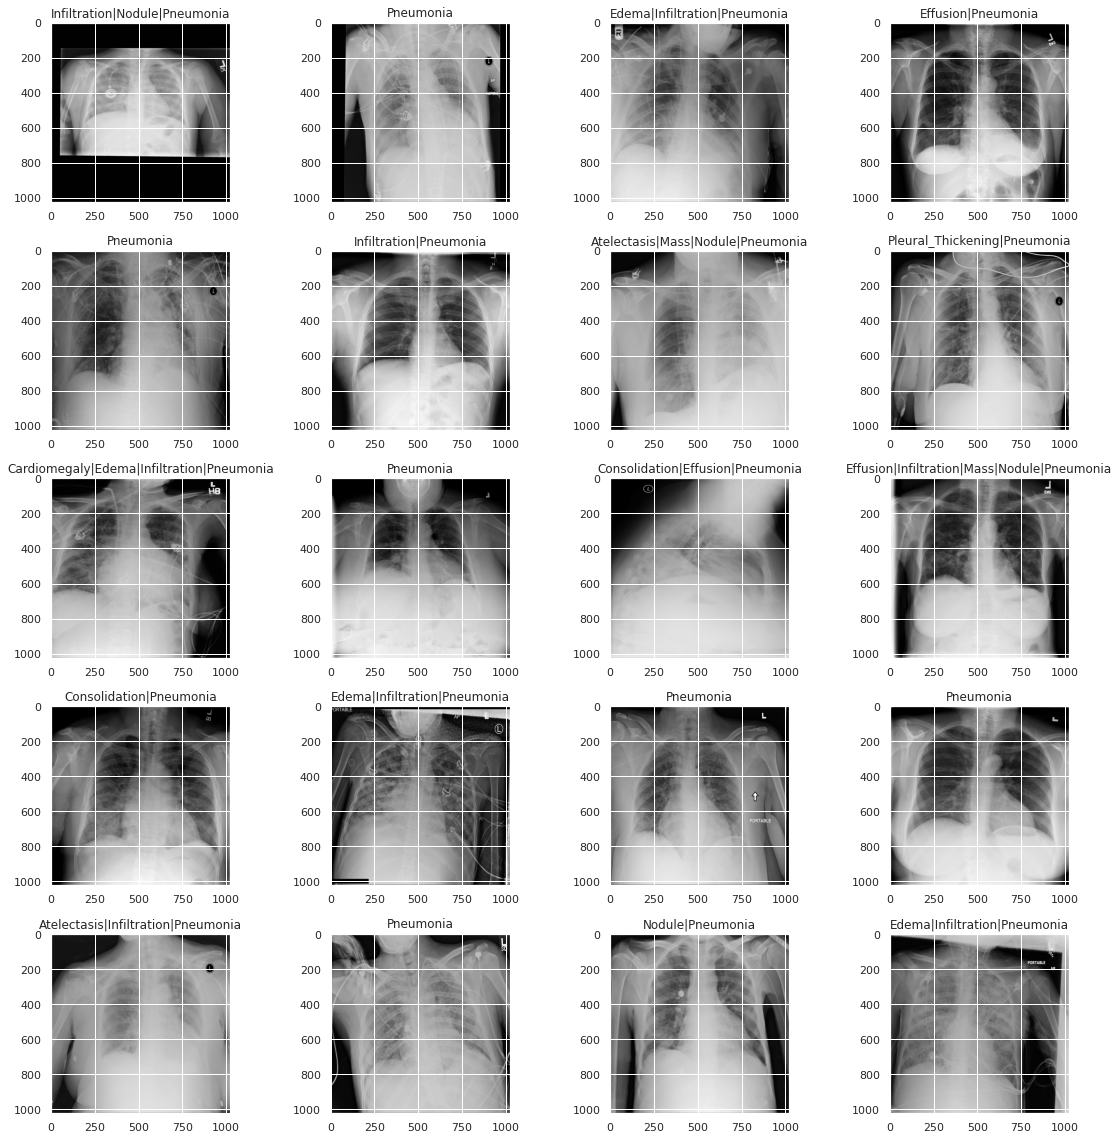

In [36]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = df_train.img_path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(df_train.iloc[ind]['Finding Labels'])
    ind=ind+1

plt.tight_layout()

## Test parameters

Play around with different values for the parameters, running the visualization cell below each time to see how these parameters change the appearance of your augmented data. Make some conclusions about what sorts of values might or might not be appropriate for medical imaging based on what you might see in the real world. You can look at the ImageDataGenerator documentation in Keras to add other parameters as well.
* horizontal_flip and vertical_flip should be set to True/False
* height_shift_range and width_shift_range should be between 0 and 1
* rotation_range can be between 0 and 180
* shear_range can be between 0 and 1
* zoom_range can be between 0 and 1

In [37]:
from skimage import exposure

def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

In [38]:
idg_temp = ImageDataGenerator(
    rescale=1.0/255,
    samplewise_center=True,
    samplewise_std_normalization= True,
    horizontal_flip = True, 
    vertical_flip = False, 
    height_shift_range= 0.05, 
    width_shift_range=0.05,
    shear_range=0.1,
    #zoom_range=0.1,
    rotation_range=5
    #zca_whitening=True,
    #preprocessing_function=AHE
)

gen_temp = idg_temp.flow_from_dataframe(
    dataframe=df_train, 
    x_col = 'img_path',
    y_col = 'class',
    class_mode = 'binary',
    target_size = img_size, 
    batch_size = 9
)

Found 2290 validated image filenames belonging to 2 classes.


Look at some examples of our augmented training data. This is helpful for understanding the extent to which data is being manipulated prior to training, and can be compared with how the raw data look prior to augmentation

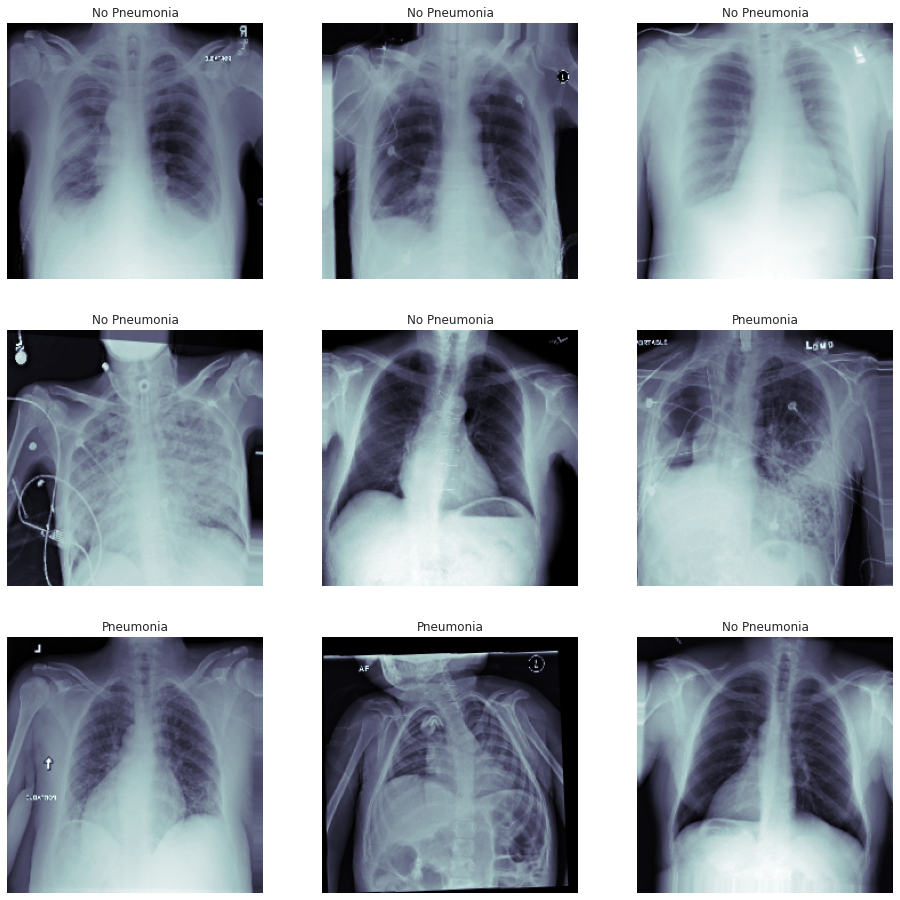

In [39]:
plot_img_gen(gen_temp, 3, 3)

## Do image augmentation

We have to build separate generators for train and val data because the train generator does a few operations that should not be done on validation data.

In [40]:
train_gen = make_train_gen(df_train, img_size)
val_gen = make_val_gen(df_val, img_size)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


May want to pull a single large batch of random validation data for testing after each epoch:

In [41]:
X_val, y_val = val_gen.next()

May want to look at some examples of our augmented training data. This is helpful for understanding the extent to which data is being manipulated prior to training, and can be compared with how the raw data look prior to augmentation.

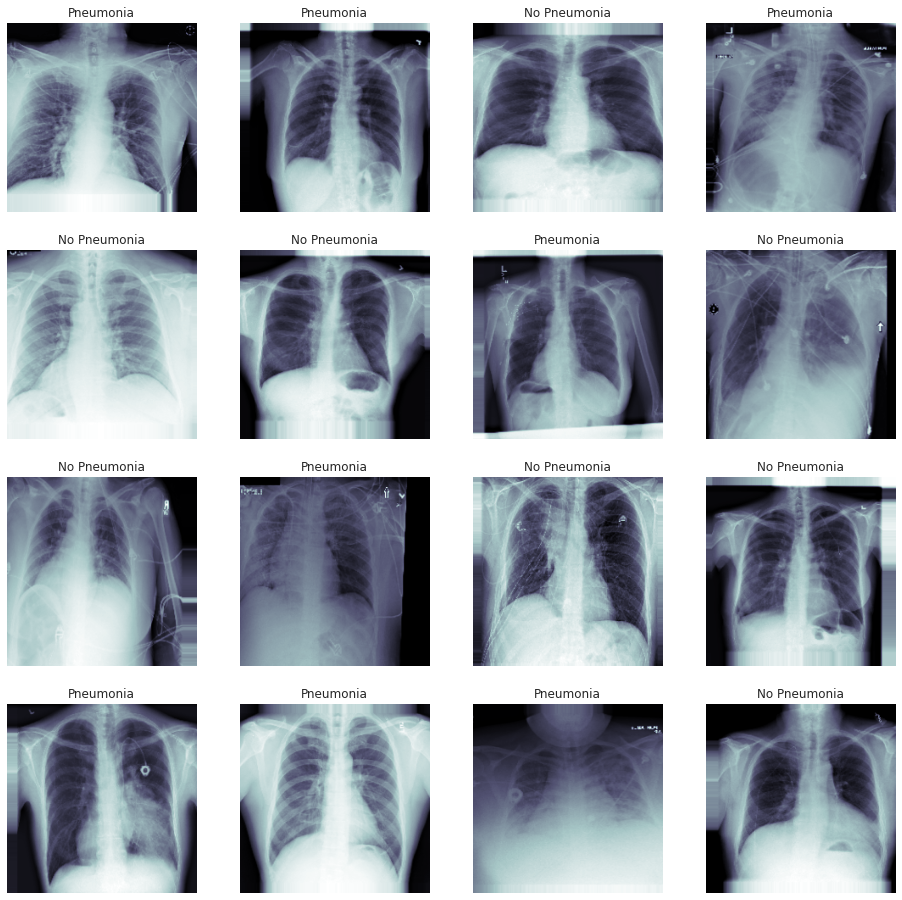

In [42]:
plot_img_gen(train_gen, 4, 4)

---

# Models

In [43]:
epochs = 100

In [44]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # will be stopped if loss does not reduce after 10 steps

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',
                                   patience=5, #if val loss not improving for 5 steps
                                   factor=0.8, #reduce by factor 0.8
                                   verbose=1,
                                   mode='auto',
                                   epsilon=0.0001,
                                   cooldown=5,
                                   min_lr=0.0001)

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [45]:
optimizer = Adam(lr=0.0001)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

# VGG Attention Model

In [46]:
X_train, y_train = next(train_gen)

In [47]:
model_name = 'vgg-attn'

In [48]:
pretrain_model = VGG16(input_shape = X_train.shape[1:],
                       include_top = False,
                       weights = 'imagenet')

pretrain_features = Input(pretrain_model.get_output_shape_at(0)[1:], name = 'feature_input')
pretrain_depth = pretrain_model.get_output_shape_at(0)[-1]
batchnorm_features = BatchNormalization(name='features_batch_norm')(pretrain_features)

attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(batchnorm_features)
attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer)
attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid', name='AttentionMap2D')(attn_layer)

up_c2_w = np.ones((1, 1, 1, pretrain_depth))
up_c2 = Conv2D(pretrain_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, batchnorm_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])

gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

attn_model = Model(inputs = [pretrain_features], outputs = [out_layer], name = 'attention_model')

attn_model.compile(optimizer = optimizer,
                   loss = loss,
                   metrics = metrics)

attn_model.summary()


Model: "attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
features_batch_norm (BatchNorma (None, 7, 7, 512)    2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 128)    65664       features_batch_norm[0][0]        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 32)     4128        conv2d_1[0][0]                   
____________________________________________________________________________________

In [49]:
model = Sequential(name = 'VGG_attention_model')
pretrain_model.trainable = False
model.add(pretrain_model)
model.add(attn_model)
model.compile(optimizer = optimizer,
              loss = loss,
              metrics = metrics)
model.summary()

Model: "VGG_attention_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
attention_model (Model)      (None, 1)                 138690    
Total params: 14,853,378
Trainable params: 137,154
Non-trainable params: 14,716,224
_________________________________________________________________


In [50]:
from keras.utils.vis_utils import model_to_dot
#Image(model_to_dot(attn_model, show_shapes=True).create_png())

In [51]:
weight_path = "weights/{}_weights.best.hdf5".format(model_name)

checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min',
                             save_weights_only = True)

callbacks_list = [checkpoint,
                  early,
                  reduceLROnPlat]

In [52]:
%%time
train_gen.batch_size = 32
history = model.fit_generator(train_gen,
                              validation_data = (X_val, y_val), 
                              steps_per_epoch=train_gen.n//train_gen.batch_size,
                              epochs = epochs,
                              callbacks = callbacks_list)

Epoch 1/100
71/71 [==============================] - 75s 1s/step - loss: 0.7488 - binary_accuracy: 0.5089 - val_loss: 0.8679 - val_binary_accuracy: 0.2793

Epoch 00001: val_loss improved from inf to 0.86794, saving model to weights/vgg-attn_weights.best.hdf5
Epoch 2/100
71/71 [==============================] - 70s 980ms/step - loss: 0.7107 - binary_accuracy: 0.5558 - val_loss: 0.8470 - val_binary_accuracy: 0.2793

Epoch 00002: val_loss improved from 0.86794 to 0.84702, saving model to weights/vgg-attn_weights.best.hdf5
Epoch 3/100
71/71 [==============================] - 70s 983ms/step - loss: 0.7087 - binary_accuracy: 0.5673 - val_loss: 0.8210 - val_binary_accuracy: 0.2822

Epoch 00003: val_loss improved from 0.84702 to 0.82104, saving model to weights/vgg-attn_weights.best.hdf5
Epoch 4/100
71/71 [==============================] - 68s 964ms/step - loss: 0.6971 - binary_accuracy: 0.5762 - val_loss: 0.8529 - val_binary_accuracy: 0.2822

Epoch 00004: val_loss did not improve from 0.82104

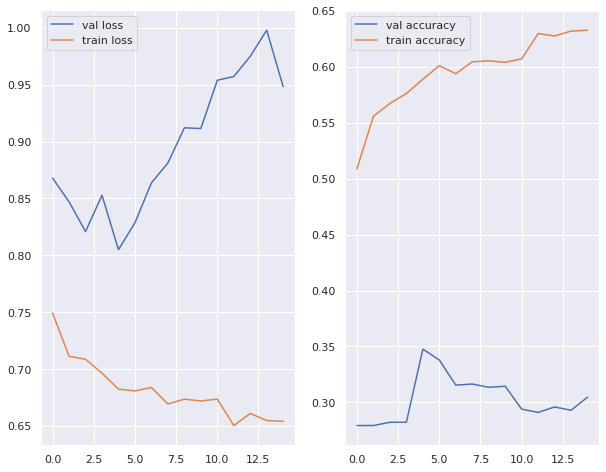

In [53]:
plot_history_sep(history, model_name)

* training loss shows improvement but a large gap remains between both validation and training curves, indicating that the training set is unrepresentative
* the validation loss is also lower than the training loss so the validation dataset might actually be easier for the model to predict than the training data set, so we might have an unrepresentative validation dataset
* finally, there is some noisy movements with validation loss, another indicator of an unrepresentative validation dataset

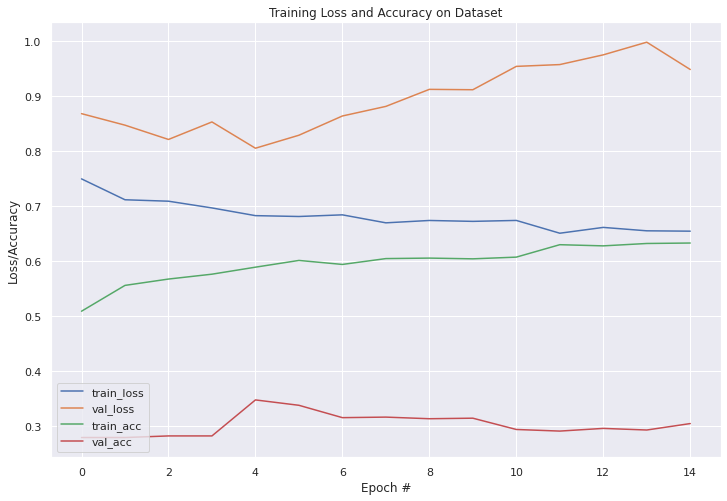

In [54]:
plot_history_tog(history, model_name)

In [55]:
model.save('{}.h5'.format(model_name))

In [56]:
model.load_weights(weight_path)

In [57]:
y_pred = model.predict(
    X_val,
    batch_size = 64,
    verbose = True
)

1024/1024 [==============================] - 15s 14ms/step


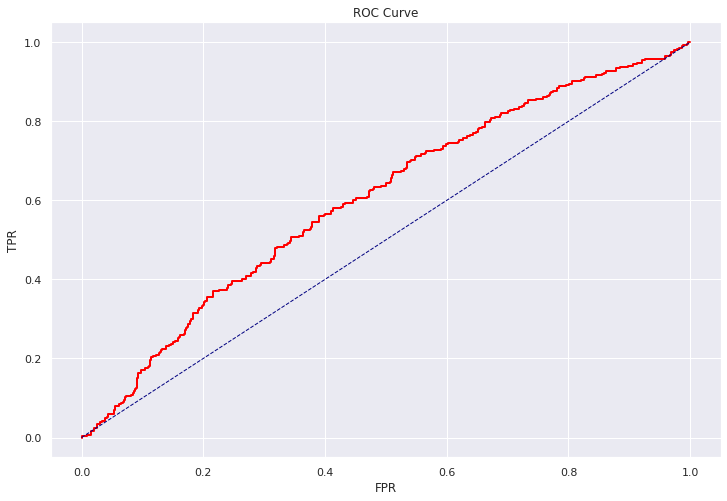

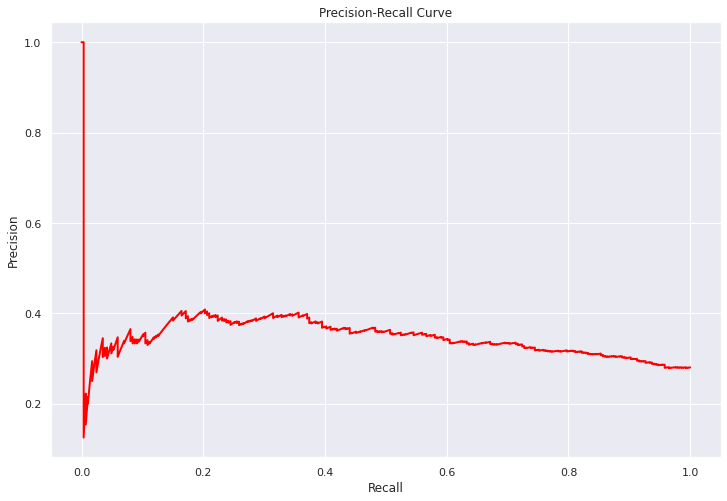

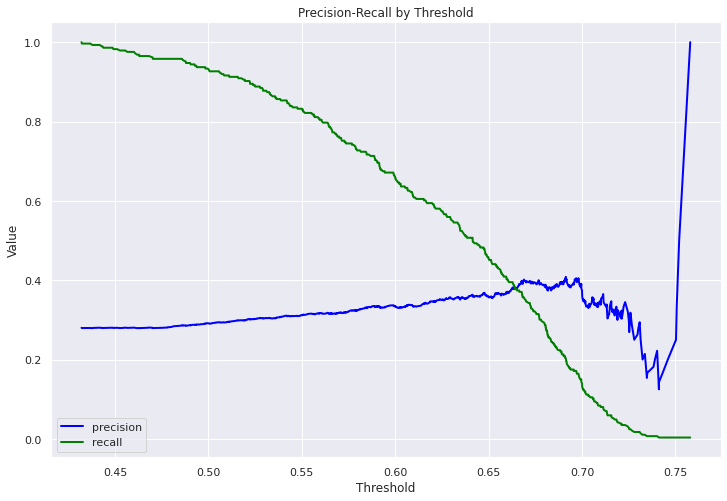

In [58]:
plot_auc(y_val, y_pred)
plot_pr(y_val, y_pred)
plot_pr_th(y_val, y_pred)

* The ROC curve indicates a bad classifier
* The PR curve indicates a bad classifier, that only reaches a high recall at a low precision 

### Inspect CAM

Let's see where our model is focusing attention on.

In [59]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in attn_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

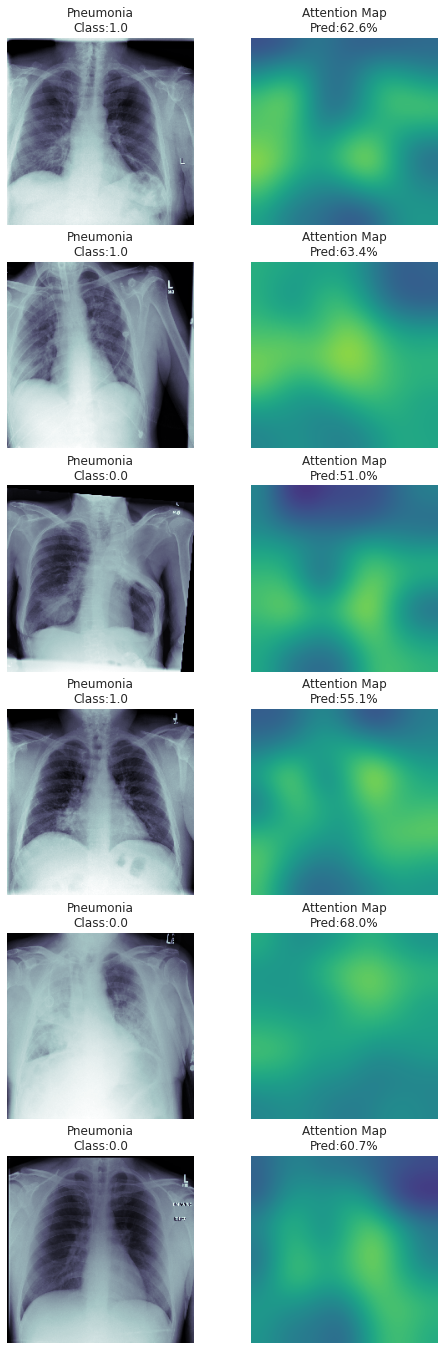

In [60]:
rand_idx = np.random.choice(range(len(X_val)), size = 6)
attn_func = K.function(inputs = [attn_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = X_val[c_idx:(c_idx+1)]
    cur_features = pretrain_model.predict(cur_img)
    attn_img = attn_func([cur_features, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_label = y_val[c_idx]
    img_ax.set_title('Pneumonia\nClass:%s' % (real_label))
    pred_confidence = model.predict(cur_img)[0]
    attn_ax.set_title('Attention Map\nPred:%2.1f%%' % (100*pred_confidence[0]))
fig.savefig('attention_map.png', dpi = 300)

Attention is still a bit all over the place, looking at the attention maps.

## Evaluate

After training, make some predictions to assess your model's overall performance. Note that detecting pneumonia is hard even for trained expert radiologists, so there is no need to make the model perfect.

In [61]:
# show a nicely formatted classification report
print(classification_report(y_val,y_pred.argmax(axis=1)))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(y_val, y_pred.argmax(axis=1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84       738
         1.0       0.00      0.00      0.00       286

    accuracy                           0.72      1024
   macro avg       0.36      0.50      0.42      1024
weighted avg       0.52      0.72      0.60      1024

[[738   0]
 [286   0]]
acc: 0.7207
sensitivity: 1.0000
specificity: 0.0000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


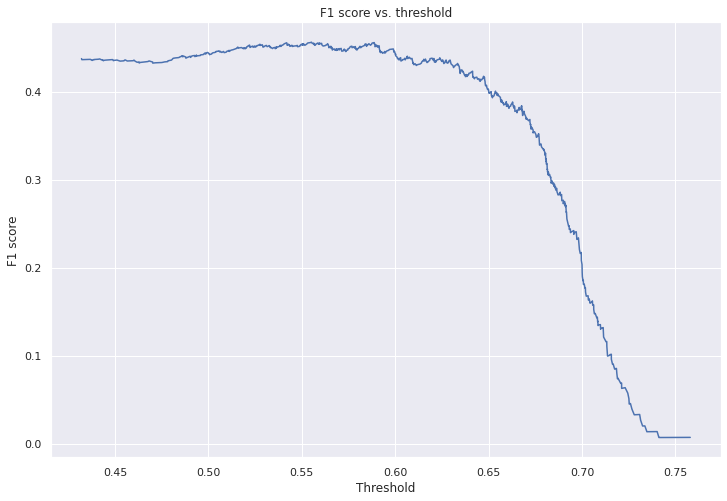

Precision: 0.31586021505376344
Recall: 0.8216783216783217
Threshold: 0.55517066
F1 Score: 0.4563106796116505


In [62]:
th_optimal = find_optimal_th(y_val, y_pred)

In [63]:
tn, fp, fn, tp = confusion_matrix(y_val, (y_pred > th_optimal).astype(int)).ravel()

In [64]:
npv = tn / (tn + fn)
ppv = tp / (tp + fp)
spec = tn / (tn + fp)

In [65]:
print(npv)
print(ppv)
print(spec)

0.8149466192170819
0.3149394347240915
0.31029810298102983


The higher recall falls at the cost of lower precision (0.3159), which is a 68.41% chance that a positive prediction (pneumonia) is a false positive (not actually pneumonia).

NPV is 0.8149, which means that when the model predicts negative (no pneumonia), it is right with 81.49% of the cases.

PPV is 0.3149, which means that when the model predicts positive (pneumonia), it is right with 31.49% of the cases.

In [66]:
YOUR_THRESHOLD = th_optimal

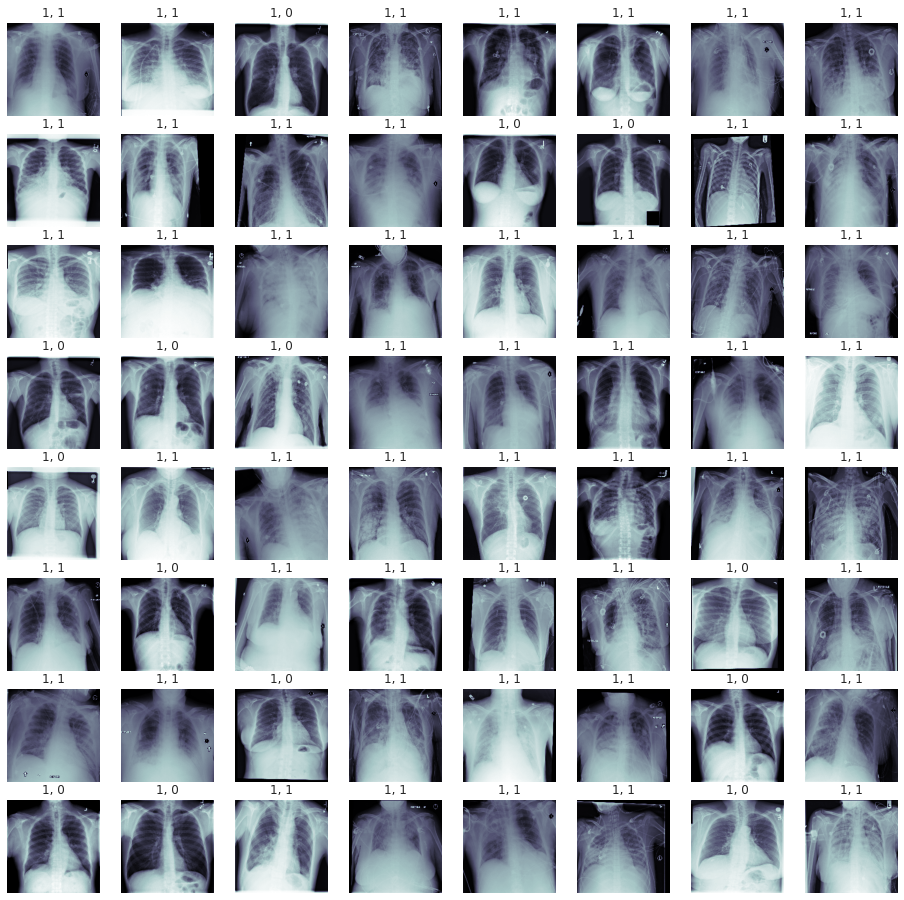

In [67]:
fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0

for (c_x, c_y, c_ax) in zip(X_val[0:64], y_val[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if y_pred[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if y_pred[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [68]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("{}-model.json".format(model_name), "w") as json_file:
    json_file.write(model_json)

# Pre-trained: Mobile Net

In [69]:
model_name = 'mobnet'
model = build_model_mobnet()
model.summary()

/opt/conda/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
____________________________________________________________

In [70]:
weight_path = "weights/{}_weights.best.hdf5".format(model_name)

checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min',
                             save_weights_only = True)

callbacks_list = [checkpoint,
                  early,
                  reduceLROnPlat]

In [71]:
model.compile(optimizer = optimizer,
              loss = loss,
              metrics = metrics)

In [72]:
%%time
train_gen.batch_size = 32
history = model.fit_generator(train_gen,
                              validation_data = (X_val, y_val), 
                              steps_per_epoch=train_gen.n//train_gen.batch_size,
                              epochs = epochs,
                              callbacks = callbacks_list)

Epoch 1/100
71/71 [==============================] - 66s 931ms/step - loss: 0.6996 - binary_accuracy: 0.5921 - val_loss: 0.7481 - val_binary_accuracy: 0.5498

Epoch 00001: val_loss improved from inf to 0.74806, saving model to weights/mobnet_weights.best.hdf5
Epoch 2/100
71/71 [==============================] - 64s 907ms/step - loss: 0.6256 - binary_accuracy: 0.6577 - val_loss: 1.2441 - val_binary_accuracy: 0.3086

Epoch 00002: val_loss did not improve from 0.74806
Epoch 3/100
71/71 [==============================] - 63s 893ms/step - loss: 0.5867 - binary_accuracy: 0.6904 - val_loss: 1.1240 - val_binary_accuracy: 0.3271

Epoch 00003: val_loss did not improve from 0.74806
Epoch 4/100
71/71 [==============================] - 63s 890ms/step - loss: 0.5585 - binary_accuracy: 0.7090 - val_loss: 1.4586 - val_binary_accuracy: 0.2920

Epoch 00004: val_loss did not improve from 0.74806
Epoch 5/100
71/71 [==============================] - 61s 865ms/step - loss: 0.5126 - binary_accuracy: 0.7520 -

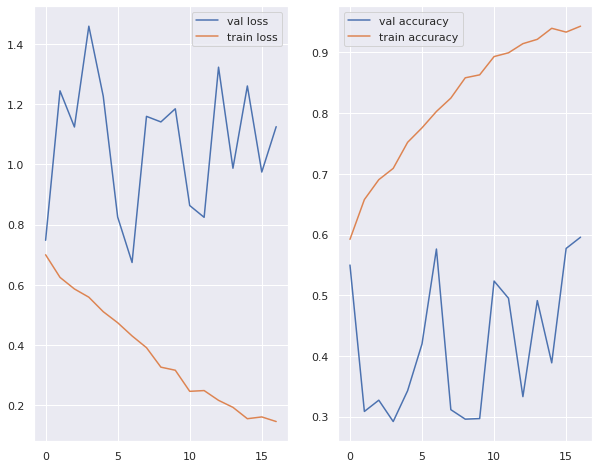

In [73]:
plot_history_sep(history, model_name)

Training loss is decreasing and accuracy increasing. However, the validation loss and accuracy seem instable – there is a lot of noisy movements, and the validation performs worse. This indicates an unrepresentative validation dataset.

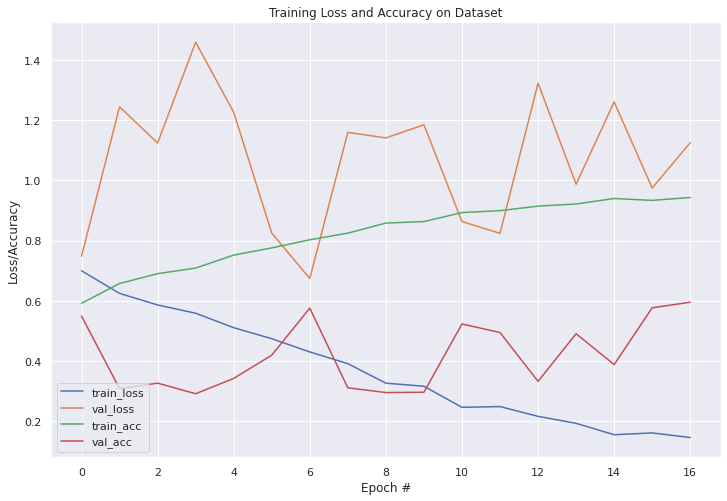

In [74]:
plot_history_tog(history, model_name)

In [75]:
model.save('{}.h5'.format(model_name))

In [76]:
model.load_weights(weight_path)

In [77]:
y_pred = model.predict(
    X_val,
    batch_size = 64,
    verbose = True
)

1024/1024 [==============================] - 6s 6ms/step


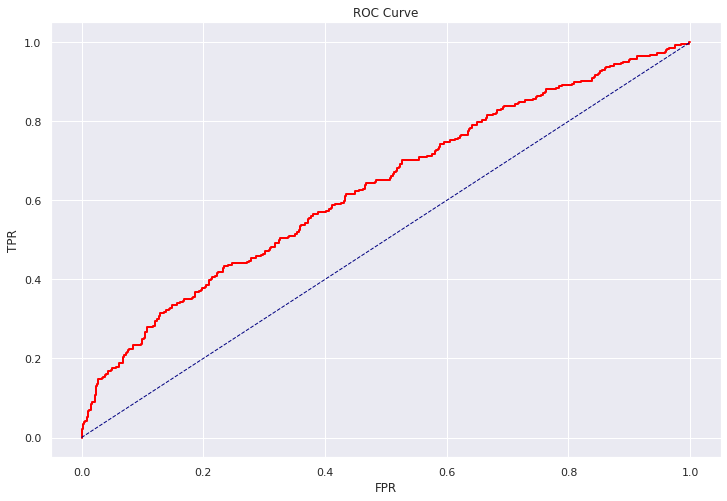

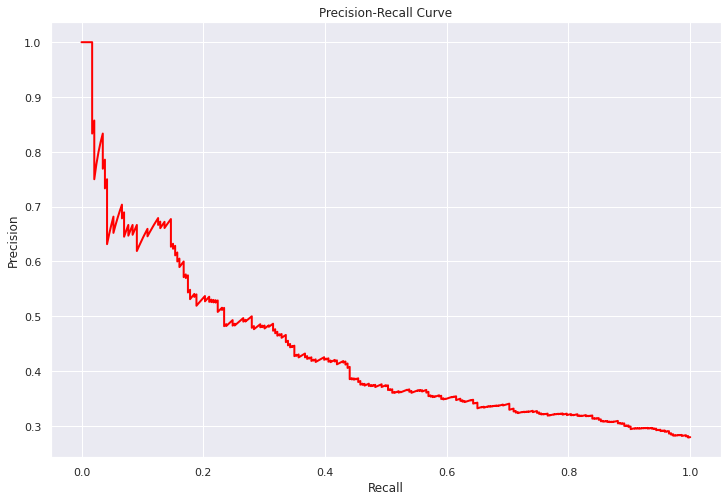

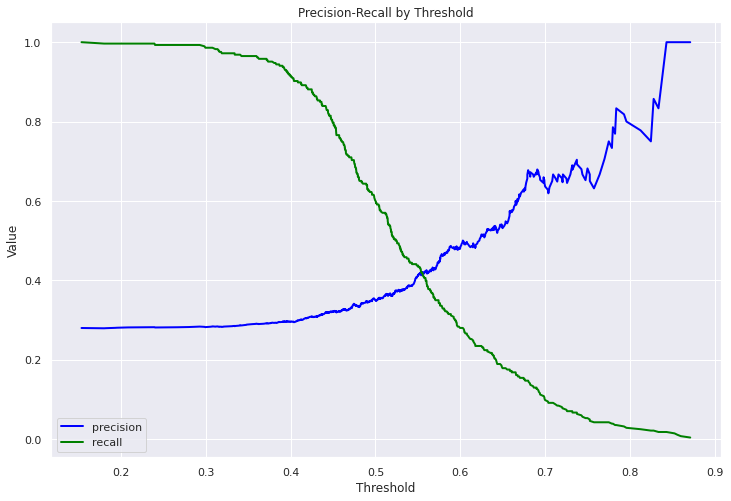

In [78]:
plot_auc(y_val, y_pred)
plot_pr(y_val, y_pred)
plot_pr_th(y_val, y_pred)

* The ROC curve indicates a bad classifier
* The PR curve indicates a bad classifier, that only reaches a high recall at a low precision

In [79]:
# show a nicely formatted classification report
print(classification_report(y_val,y_pred.argmax(axis=1)))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(y_val, y_pred.argmax(axis=1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84       738
         1.0       0.00      0.00      0.00       286

    accuracy                           0.72      1024
   macro avg       0.36      0.50      0.42      1024
weighted avg       0.52      0.72      0.60      1024

[[738   0]
 [286   0]]
acc: 0.7207
sensitivity: 1.0000
specificity: 0.0000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


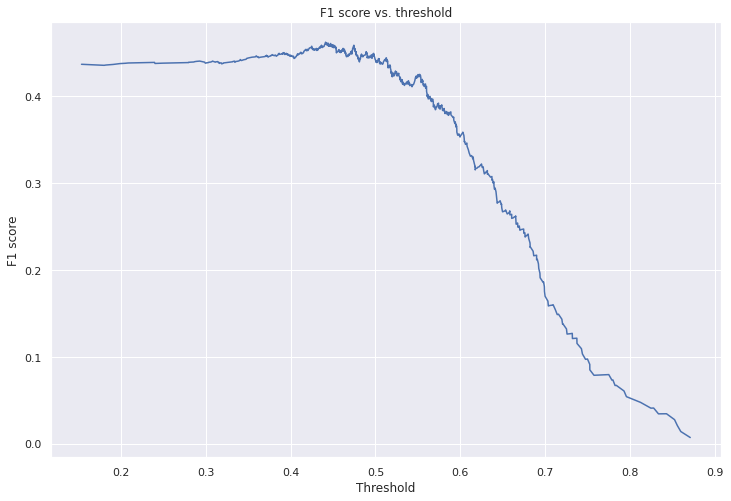

Precision: 0.3191489361702128
Recall: 0.8391608391608392
Threshold: 0.4413156
F1 Score: 0.46242774566473993


In [80]:
th_optimal = find_optimal_th(y_val, y_pred)

In [81]:
tn, fp, fn, tp = confusion_matrix(y_val, (y_pred > th_optimal).astype(int)).ravel()

In [82]:
npv = tn / (tn + fn)
ppv = tp / (tp + fp)
spec = tn / (tn + fp)

In [83]:
print(npv)
print(ppv)
print(spec)

0.8278388278388278
0.3182423435419441
0.3062330623306233


The higher recall falls at the cost of lower precision (0.3191), which is a 68.09% chance that a positive prediction (pneumonia) is a false positive (not actually pneumonia).

NPV is 0.8278, which means that when the model predicts negative (no pneumonia), it is right with 82.78% of the cases.

PPV is 0.3182, which means that when the model predicts positive (pneumonia), it is right with 31.82% of the cases.

In [84]:
YOUR_THRESHOLD = th_optimal

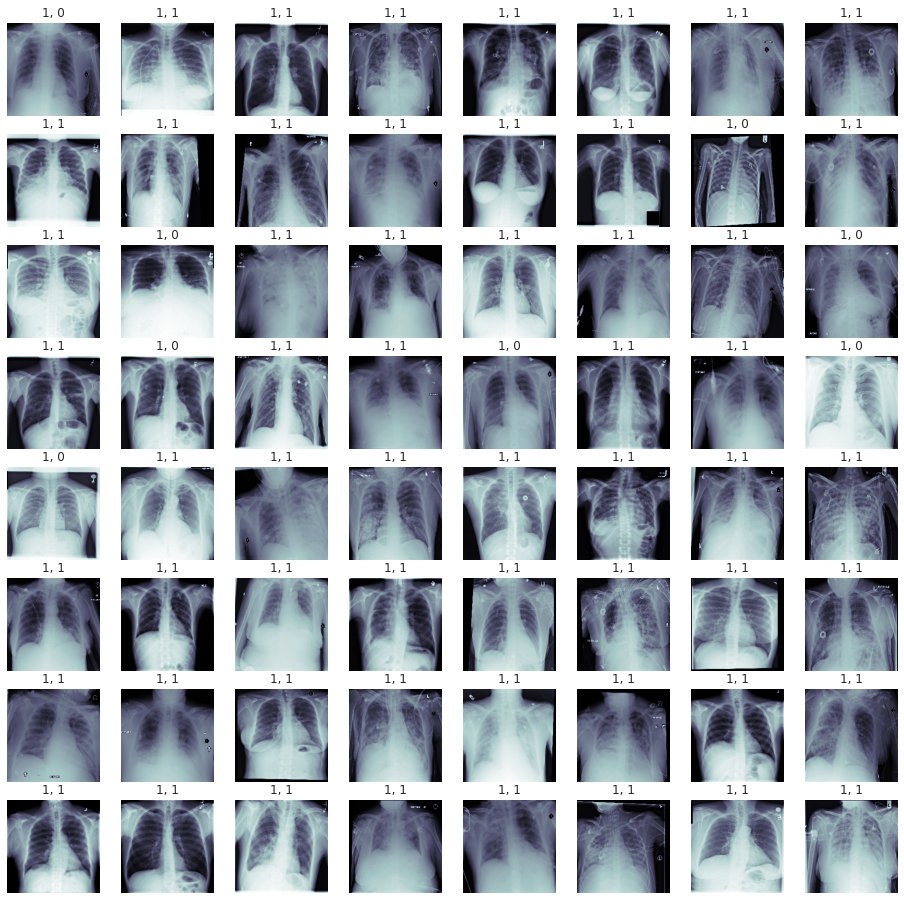

In [85]:
fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0

for (c_x, c_y, c_ax) in zip(X_val[0:64], y_val[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if y_pred[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if y_pred[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [86]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("{}-model.json".format(model_name), "w") as json_file:
    json_file.write(model_json)

---

# Compare Models

What we want to have is that with every epoch, training loss should be decreasing and accuracy should be increasing. For val_loss and val_acc, other things could happen:
1. `val_loss` increases, `val_acc` decreases -> model is cramming values not learning
2. `val_loss` increases, `val_acc` increases -> model could be overfitting 
3. `val_loss` decreases, `val_acc` increases -> model learns and works fine!

Underfitting:
* The training loss remains flat regardless of training.
* The training loss continues to decrease until the end of training.

Overfitting:
* The plot of training loss continues to decrease with experience.
* The plot of validation loss decreases to a point and begins increasing again.

Unrepresentative train data:
* training loss that shows improvement and similarly a learning curve for validation loss that shows improvement, but a large gap remains between both curves

Unrepresentative val data: 
* training loss that looks like a good fit (or other fits) and a learning curve for validation loss that shows noisy movements around the training loss
* or validation loss that is lower than the training loss (val data is easier for the model to predict than train set)

Good fit:
* The plot of training loss decreases to a point of stability.
* The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

---

# Summary

## **Validation set**
* It is preferable that the distribution of classes in the validation set reflects the distribution of classes in the test set, so that performance metrics on the validation set are a good approximation of the performance metrics on the test set. In other words, the validation set should reflect the original data imbalance.
* Our validation set 

## **Data Leakage**
* The dataset contains multiple images for some patient (see EDA). The data splitting should be done on patient level to avoid data leakage.
* We have data leakage in our train and val sets, so this should be addressed in the future

## **Image Augmentation**
* Some images have black borders and are not well aligned. Would be good to address this in the future.
* Medical Image Segmentation: with Medical Image Segmentation, we can automate the detection of boundaries within images. Tasks such as detecting pneumonia in chest x-rays would be greatly facilitated by training a CNN U-Net architecture to segment lung masks. For more information, see this [Colab notebook](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb).

## **Model evaluations**

### Pretrained VGG + Attention Model
* training loss shows improvement but a large gap remains between both validation and training curves, indicating that the training set is unrepresentative
* the validation loss is also lower than the training loss so the validation dataset might actually be easier for the model to predict than the training data set, so we might have an unrepresentative validation dataset
* finally, there is some noisy movements with validation loss, another indicator of an unrepresentative validation dataset
* The ROC curve indicates a bad classifier
* The PR curve indicates a bad classifier, that only reaches a high recall at a low precision 
* An F1-score of 0.4563 is obtained with a threshold of 0.555
* The higher recall falls at the cost of lower precision (0.3159), which is a 68.41% chance that a positive prediction (pneumonia) is a false positive (not actually pneumonia).
* NPV is 0.8149, which means that when the model predicts negative (no pneumonia), it is right with 81.49% of the cases.
* PPV is 0.3149, which means that when the model predicts positive (pneumonia), it is right with 31.49% of the cases.
* The attention maps are not very coherent, and attention of the model seems to be a fair bit over the place

### Pretrained Mobile Net
* Training loss is decreasing and accuracy increasing. However, the validation loss and accuracy seem instable – there is a lot of noisy movements, and the validation performs worse. This indicates an unrepresentative validation dataset.
* The ROC curve indicates a bad classifier
* The PR curve indicates a bad classifier, that only reaches a high recall at a low precision
* An F1-score of 0.4625 is achieved with a threshold of 0.441
* The higher recall falls at the cost of lower precision (0.3191), which is a 68.09% chance that a positive prediction (pneumonia) is a false positive (not actually pneumonia).
* NPV is 0.8278, which means that when the model predicts negative (no pneumonia), it is right with 82.78% of the cases.
* PPV is 0.3182, which means that when the model predicts positive (pneumonia), it is right with 31.82% of the cases.

**Note:** these issues could be elevated by defining representative train and/or validation data, as well as making use of mask segmentations of the lungs. Labels of where the diseases in the lung are located could also help model training.

## Model choice

The VGG + attention model is chosen for submission. For more information, please refer to the FDA submisisson report.

---

# Algorithmic evaluations

In [40]:
df_val.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'img_path', 'Fibrosis',
       'No Finding', 'Pleural_Thickening', 'Pneumonia', 'Infiltration',
       'Hernia', 'Pneumothorax', 'Atelectasis', 'Nodule', 'Emphysema',
       'Consolidation', 'Mass', 'Edema', 'Cardiomegaly', 'Effusion', 'class'],
      dtype='object')

In [41]:
from time import time
from matplotlib.image import imread
from skimage.transform import resize

In [42]:
def preprocess_image(img,img_size):
    img_mean = np.mean(img)
    img_std = np.std(img)
    proc_img = cv2.resize(img, img_size)
    proc_img = (proc_img - img_mean)/img_std
    proc_img = np.resize(proc_img,(224,224,3))
    return np.expand_dims(proc_img, 0)

def predict_image_proba(model, img): 
    return model.predict(img)[0][0]

In [43]:
def predict_val(row):
    ind = row.name
    path = row['img_path']
    
    ts = time()
    img_data = imread(path)
    proc_img = preprocess_image(img_data, img_size)
    time_load_img = time() - ts
    
    ts = time()
    result = predict_image_proba(model, proc_img)
    time_predict_img = time() - ts

    return pd.Series([result, time_load_img, time_predict_img])

In [44]:
def timer(elapsed_time):
    return time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

In [51]:
model_name = 'vgg-attn'
weight_path = "weights/{}_weights.best.hdf5".format(model_name)
model = load_model('{}-model.json'.format(model_name), weight_path)
model.load_weights(weight_path)
th_optimal = 0.55517066

In [52]:
df_val_attn = df_val.copy()

In [53]:
%%time
df_val_attn[['pneumonia_pred', 'time_load_img', 'time_pred_img']] = df_val_attn.apply(lambda x: predict_val(x), axis=1) # apply to each row
df_val_attn['pneumonia_pred_th'] = df_val_attn.apply(lambda x: int(x['pneumonia_pred'] > th_optimal), axis=1)

CPU times: user 13min 52s, sys: 1.59 s, total: 13min 53s
Wall time: 13min 59s


In [54]:
df_val_attn.head()

Image Index                       Finding Labels  Follow-up #  \
66771   00016508_012.png              Consolidation|Pneumonia           12   
68905   00016991_008.png  Edema|Infiltration|Nodule|Pneumonia            8   
66489   00016434_001.png            Effusion|Nodule|Pneumonia            1   
109749  00029861_013.png         Edema|Infiltration|Pneumonia           13   
65074   00016064_010.png              Effusion|Mass|Pneumonia           10   

        Patient ID  Patient Age  Patient Gender View Position  \
66771        16508           51             0.0            AP   
68905        16991           31             0.0            PA   
66489        16434           61             1.0            PA   
109749       29861           63             0.0            AP   
65074        16064           55             1.0            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
66771                  2500     2048                        0.168  ...   
68905                  2048     2500                        0.168  ...   
66489                  2992     2991                        0.143  ...   
109749                 3056     2544                        0.139  ...   
65074                  2992     2991                        0.143  ...   

        Consolidation Mass  Edema  Cardiomegaly  Effusion  class  \
66771               1    0      0             0         0      P   
68905               0    0      1             0         0      P   
66489               0    0      0             0         1      P   
109749              0    0      1             0         0      P   
65074               0    1      0             0         1      P   

        pneumonia_pred  time_load_img  time_pred_img  pneumonia_pred_th  
66771         0.796838       0.022152       0.553648                  1  
68905         0.290532       0.025681       0.556564                  0  
66489         0.379908       0.024098       0.557024                  0  
109749        0.776159       0.026755       0.565275                  1  
65074         0.384460       0.024679       0.570268                  0  

[5 rows x 32 columns]

In [55]:
all_labels = [
    'Atelectasis',
    'Cardiomegaly',
    'Consolidation',
    'Edema',
    'Effusion',
    'Emphysema',
    'Fibrosis',
    'Hernia',
    'Infiltration',
    'Mass',
    'No Finding',
    'Nodule',
    'Pleural_Thickening',
    'Pneumonia',
    'Pneumothorax'
]

In [56]:
for i in all_labels:

    tn, fp, fn, tp = confusion_matrix(df_val_attn[df_val_attn[i]==1].Pneumonia.values,
                                      df_val_attn[df_val_attn[i]==1].pneumonia_pred_th.values,labels=[1,0]).ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    print(i)
    print('Sensitivity: '+ str(sens))
    print('Specificity: ' +str(spec))
    print()

Atelectasis
Sensitivity: 0.7053571428571429
Specificity: 0.3469387755102041

Cardiomegaly
Sensitivity: 0.7037037037037037
Specificity: 0.5833333333333334

Consolidation
Sensitivity: 0.8372093023255814
Specificity: 0.2857142857142857

Edema
Sensitivity: 0.65
Specificity: 0.36619718309859156

Effusion
Sensitivity: 0.6644295302013423
Specificity: 0.38461538461538464

Emphysema
Sensitivity: 0.6818181818181818
Specificity: 0.25

Fibrosis
Sensitivity: 0.875
Specificity: 0.0

Hernia
Sensitivity: 1.0
Specificity: 0.0

Infiltration
Sensitivity: 0.6747572815533981
Specificity: 0.3392857142857143

Mass
Sensitivity: 0.7971014492753623
Specificity: 0.15384615384615385

No Finding
Sensitivity: 0.8360128617363344
Specificity: nan

Nodule
Sensitivity: 0.8470588235294118
Specificity: 0.2222222222222222

Pleural_Thickening
Sensitivity: 0.7567567567567568
Specificity: 0.0

Pneumonia
Sensitivity: nan
Specificity: 0.3041958041958042

Pneumothorax
Sensitivity: 0.8979591836734694
Specificity: 0.3333333333333

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [57]:
model_name = 'mobnet'
weight_path = "weights/{}_weights.best.hdf5".format(model_name)
model = load_model('{}-model.json'.format(model_name), weight_path)
model.load_weights(weight_path)
th_optimal = 0.4413156

In [58]:
df_val_mobnet = df_val.copy()

In [59]:
%%time
df_val_mobnet[['pneumonia_pred', 'time_load_img', 'time_pred_img']] = df_val_mobnet.apply(lambda x: predict_val(x), axis=1)
df_val_mobnet['pneumonia_pred_th'] = df_val_mobnet.apply(lambda x: int(x['pneumonia_pred'] > th_optimal), axis=1)

CPU times: user 2min 51s, sys: 399 ms, total: 2min 51s
Wall time: 2min 53s


In [60]:
df_val_mobnet.head()

Image Index                       Finding Labels  Follow-up #  \
66771   00016508_012.png              Consolidation|Pneumonia           12   
68905   00016991_008.png  Edema|Infiltration|Nodule|Pneumonia            8   
66489   00016434_001.png            Effusion|Nodule|Pneumonia            1   
109749  00029861_013.png         Edema|Infiltration|Pneumonia           13   
65074   00016064_010.png              Effusion|Mass|Pneumonia           10   

        Patient ID  Patient Age  Patient Gender View Position  \
66771        16508           51             0.0            AP   
68905        16991           31             0.0            PA   
66489        16434           61             1.0            PA   
109749       29861           63             0.0            AP   
65074        16064           55             1.0            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
66771                  2500     2048                        0.168  ...   
68905                  2048     2500                        0.168  ...   
66489                  2992     2991                        0.143  ...   
109749                 3056     2544                        0.139  ...   
65074                  2992     2991                        0.143  ...   

        Consolidation Mass  Edema  Cardiomegaly  Effusion  class  \
66771               1    0      0             0         0      P   
68905               0    0      1             0         0      P   
66489               0    0      0             0         1      P   
109749              0    0      1             0         0      P   
65074               0    1      0             0         1      P   

        pneumonia_pred  time_load_img  time_pred_img  pneumonia_pred_th  
66771         0.383135       0.022795       0.100411                  0  
68905         0.243552       0.023383       0.106060                  0  
66489         0.596025       0.022034       0.098148                  1  
109749        0.961910       0.023703       0.097404                  1  
65074         0.685708       0.021263       0.097286                  1  

[5 rows x 32 columns]

In [61]:
for i in all_labels:

    tn, fp, fn, tp = confusion_matrix(df_val_mobnet[df_val_mobnet[i]==1].Pneumonia.values,
                                      df_val_mobnet[df_val_mobnet[i]==1].pneumonia_pred_th.values,labels=[1,0]).ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    print(i)
    print('Sensitivity: '+ str(sens))
    print('Specificity: ' +str(spec))
    print()

Atelectasis
Sensitivity: 0.6875
Specificity: 0.20408163265306123

Cardiomegaly
Sensitivity: 0.5555555555555556
Specificity: 0.16666666666666666

Consolidation
Sensitivity: 0.7209302325581395
Specificity: 0.35714285714285715

Edema
Sensitivity: 0.65
Specificity: 0.43661971830985913

Effusion
Sensitivity: 0.6241610738255033
Specificity: 0.38461538461538464

Emphysema
Sensitivity: 0.5454545454545454
Specificity: 0.25

Fibrosis
Sensitivity: 0.6875
Specificity: 0.0

Hernia
Sensitivity: 1.0
Specificity: 0.0

Infiltration
Sensitivity: 0.6019417475728155
Specificity: 0.4107142857142857

Mass
Sensitivity: 0.5942028985507246
Specificity: 0.23076923076923078

No Finding
Sensitivity: 0.6077170418006431
Specificity: nan

Nodule
Sensitivity: 0.6705882352941176
Specificity: 0.5

Pleural_Thickening
Sensitivity: 0.7027027027027027
Specificity: 0.5714285714285714

Pneumonia
Sensitivity: nan
Specificity: 0.4020979020979021

Pneumothorax
Sensitivity: 0.7551020408163265
Specificity: 0.6666666666666666



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [62]:
#timer(img_load_time)
#timer(img_pred_time)

In [82]:
df_val_attn[['time_load_img', 'time_pred_img']].describe()

time_load_img  time_pred_img
count    1430.000000    1430.000000
mean        0.022897       0.563156
std         0.002929       0.017623
min         0.016511       0.547390
25%         0.021226       0.555984
50%         0.022498       0.560794
75%         0.023880       0.567411
max         0.062839       0.839248

In [85]:
timer(df_val_attn['time_load_img'].describe()['max'])

'00:00:00'

In [86]:
timer(df_val_attn['time_pred_img'].describe()['max'])

'00:00:00'

In [73]:
df_val_mobnet[['time_load_img', 'time_pred_img']].describe()

time_load_img  time_pred_img
count    1430.000000    1430.000000
mean        0.022115       0.097437
std         0.002222       0.007152
min         0.015939       0.094135
25%         0.021101       0.096058
50%         0.021792       0.096764
75%         0.023002       0.097697
max         0.044586       0.283508

In [87]:
timer(df_val_mobnet['time_load_img'].describe()['max'])

'00:00:00'

In [88]:
timer(df_val_mobnet['time_pred_img'].describe()['max'])

'00:00:00'